In [12]:
%run '../ego.py'
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib
%run '../preprocess.py'
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import numpy as np
sns.set_style('ticks');
sns.set_palette('Set1')
import json
from pymc3 import *
%load_ext line_profiler

## Raw Data intake

In [3]:
pre = Preprocess(all_dat='../all_games.pkl', pca_model='../eco_full_pca.pkl')

# pre = Preprocess()
# pre.get_json('alluser_control.json')  # uncomment this to create the pkl file needed!!
# pre.train_pca()

X, y = pre.ready_player_one(2)

# scale = StandardScaler()
scale = MinMaxScaler((-1.,1.))
X = scale.fit_transform(X)


from tqdm import tqdm

file_address = 'p2_bfgs_sigma_alpha8.286TRUNCATED.json'
with open(file_address, 'r') as f:
    # pickle.dump([obj_set, sigma_set], f)
    best_obj, best_sig = json.load( f)
f.close()


unit_sig = np.ones(31)
bounds = np.array(31*[[-1., 1.]])
bestKrig = Kriging(best_sig, bounds=bounds)
# bestKrig.fit(X[:12],y[:12])
bestKrig.fit(X,y)


## MCMC Testing
### Univariate Example

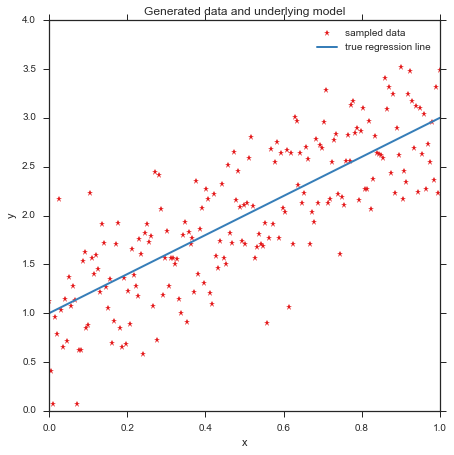

In [3]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

data = dict(x=x, y=y)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, '*', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

In [12]:
with Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy('sigma', beta=10, testval=1.)
    intercept = 5*Beta('Intercept',1,1)
    x_coeff = 5*Beta('x', 1,1)

    # Define likelihood
    likelihood = Normal('y', mu=intercept + x_coeff * x, 
                        sd=sigma, observed=y)

Applied log-transform to sigma and added transformed sigma_log to model.
Applied logodds-transform to Intercept and added transformed Intercept_logodds to model.
Applied logodds-transform to x and added transformed x_logodds to model.


In [13]:
with model:
# Inference!
#     start = find_MAP() # Find starting value by optimization
    start = {'Intercept_logodds': np.array(-1.4488360894175776),
             'sigma_log': np.array(-0.7958719902826098),
             'x_logodds': np.array(-0.3564261325183015)}
    step = NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = sample(2000, step, start=start, progressbar=True) # draw 2000 posterior samples using NUTS sampling

 [-----------------100%-----------------] 2000 of 2000 complete in 1.3 sec

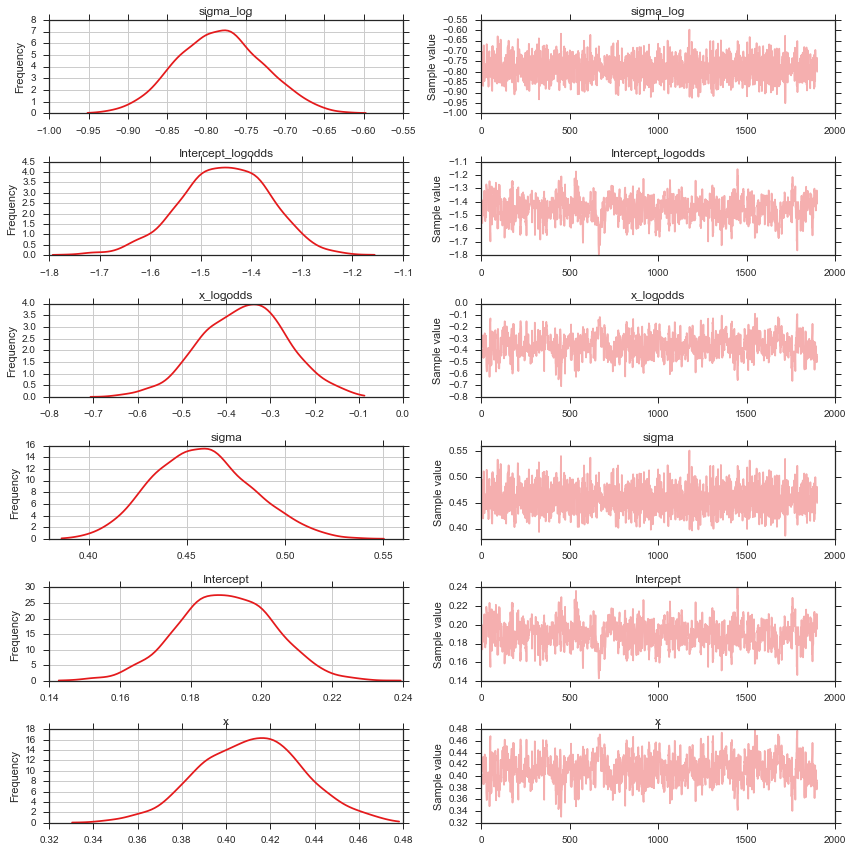

In [14]:
plt.figure(figsize=(7, 7))
traceplot(trace[100:])
plt.tight_layout();

In [22]:
start

{'Intercept_logodds': array(-1.4488360894175776),
 'sigma_log': array(-0.7958719902826098),
 'x_logodds': array(-0.3564261325183015)}

### Multivariate MCMC

In [62]:
size = 200
true_intercept = 1
true_slope = range(-5, 5)

x = np.linspace(0, 1, size)
x_dim = 10*[x]
# print x_dim

X, ind = np.meshgrid(x, range(10))
print X.shape
# y = a + b*x
true_regression_line = true_intercept + np.dot(true_slope,X)
# add noise
y = np.add(true_regression_line,np.random.normal(scale=.5, size=(10, size)))

print y.shape
plt.figure(figsize = (6,3))
plt.imshow(y)
data = dict(x=x, y=y)


with Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy('sigma', beta=10, testval=1.)
    intercept = Normal('Intercept',1,1)
    x_coeff = Normal('x', 1,sd=sigma, shape=10)

    # Define likelihood
    likelihood = Normal('y', mu=intercept + x_coeff * X.T, 
                        sd=sigma, observed=y.T)

with model:
# Inference!
#     start = find_MAP() # Find starting value by optimization
    start = {'Intercept': np.array(1.),
             'sigma_log': np.array(-0.7958719902826098),
             'x': np.arange(-5,5)}
    step = NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = sample(2000, step, start=start, progressbar=True) # draw 2000 posterior samples using NUTS sampling

 [-----------------100%-----------------] 2000 of 2000 complete in 2.7 sec

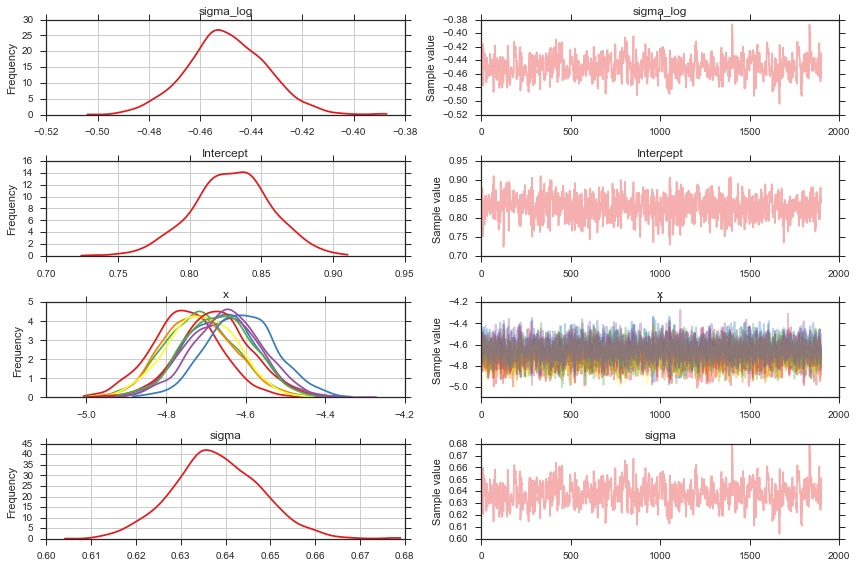

In [63]:
plt.figure(figsize=(7, 7))
traceplot(trace[100:])
plt.tight_layout();

### Attempt w/o Observed:

In [107]:
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import time


with Model() as model:
    x = Uniform('x',0,10, shape=2)
     
    @theano.compile.ops.as_op(itypes=[theano.tensor.dvector],otypes=[theano.tensor.dscalar])
    def nrg(x):
        return -(x[0]-4)**2 - 2*(x[1]-9)**4
#     likelihood = Potential('z',nrg)
    likelihood = DensityDist('z',lambda x: -(x[0]-4)**2 - 2*(x[1]-9)**4, shape=2, testval=[1,1])
    # global maximum z=0 at x=(4,9)
    
    start = find_MAP()
#     print start
    step = Metropolis()
    trace = sample(2000, step, start=start, progressbar=True)


Applied interval-transform to x and added transformed x_interval to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 0.6 sec


x_interval:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.077           1.631            0.096            [-3.318, 3.177]
  0.150            1.887            0.122            [-3.066, 4.546]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -3.666         -1.064         -0.081         1.030          3.124
  -3.593         -0.959         0.079          1.256          4.123


z:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  4.016            0.695            0.042            [2.839, 5.627]
  8.987            0.500            0.027            [8.114, 9.870]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f530ceffdd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f5308b13650>]], dtype=object)

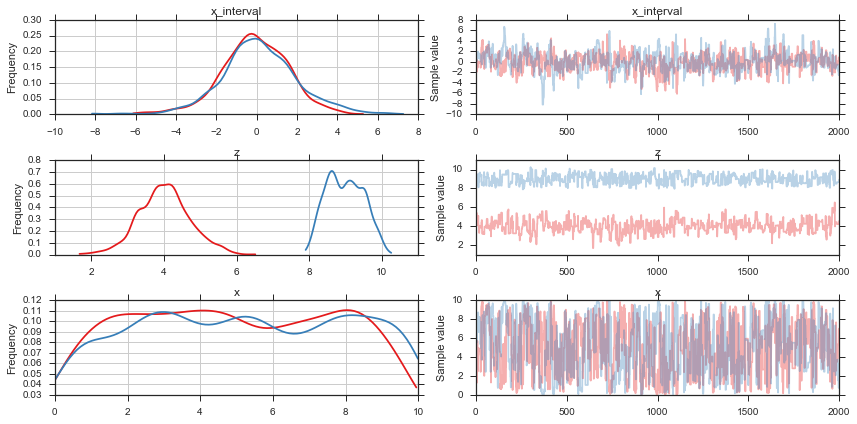

In [108]:
print summary(trace)
traceplot(trace)

seems to be working...It should be finding the $x$ such that the likelihood is maximized near the expected value of the sampled distribution, which seems to be being dumped into the $z$ output... notice the peak is at 4 and 9, respectively? That's the global max of $z$.  



## ICA k-selection

In [31]:
N,Tdim = pre.all_dat.shape
print " N={0} samples of dimention T={1}".format(N,Tdim)
# np.memmap
cov = np.cov(pre.all_dat, rowvar=0)  # errors on order of 1e-13
# iu = np.triu_indices(18160)
# il = np.tril_indices(18160) 
# cov[iu] = cov[il]  
cov = (cov+cov.T)/2.

 N=2250 samples of dimention T=18160


In [33]:
(np.tril(cov) - np.triu(cov).transpose()).argmin(axis=1)
# np.argmin()

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [34]:
(cov==cov.transpose()).all()

True

In [35]:
# cov.shape
eigs = np.linalg.eigvalsh(cov)
del cov

In [ ]:
eigs = np.abs(eigs[::-1])

In [89]:
# np.abs(eigs).sum()
eigs_k = eigs[30+1:]
# np.sum(eigs_k)
eigs_k.sum()/(Tdim-30)
np.power(eigs_k, 1./(Tdim-30))
np.log(eigs_k)
# eigs_k

array([ 2.77178441,  2.7356646 ,  2.6928489 , ...,        -inf,
              -inf,        -inf])

In [57]:
N,Tdim = pre.all_dat.shape
print " N={0} samples of dimention T={1}".format(N,Tdim)

def sig_AIC(k):
    eigs_k = np.abs(eigs[::-1][k+1:])
#     logf = N*np.sum(np.log(eigs)) -\
#     N*(T-k)*np.log(np.sum(eigs)/(T-k))
#     print N*np.sum(np.log(eigs))
    
#     G_bias = k*(2*T-k)
    
    num = np.prod(np.power(eigs_k, 1./(Tdim-k)))
    print num
    den = np.sum(eigs_k)/(Tdim-k)
    print den
    logf = np.power(np.log(num/den), Tdim-k)*N/2.
    
    G_bias = 1+Tdim*k - k*(k-1)/2.
    
    return -logf + 0.5*G_bias*np.log(N)
sig_AIC(30)

 N=2250 samples of dimention T=18160
0.0
0.031415164847


-inf

In [84]:
np.log(eigs[10000:])

array([-68.05376233, -68.05030516, -68.04682231, ...,   6.23857953,
         6.69595098,   7.36198608])

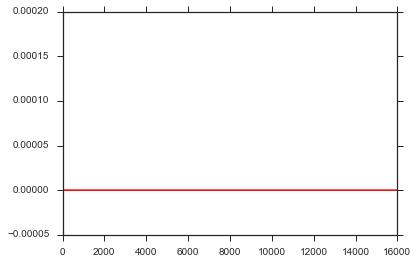

In [139]:
plt.plot(eigs[16000::-1])

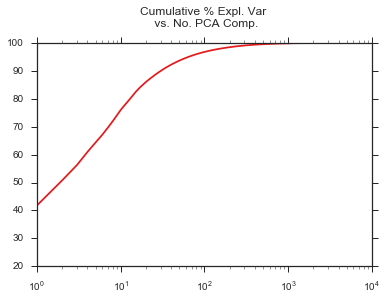

In [175]:
from sklearn.decomposition import PCA, FastICA

pca = PCA()
pca.fit(pre.all_dat)
# del pca
plt.plot(100*(pca.explained_variance_.cumsum()/pca.explained_variance_.sum()))
plt.xscale('log')
plt.title('Cumulative % Expl. Var \n vs. No. PCA Comp.\n')

In [110]:
pca = PCA(n_components=1000)
new_dat = pca.fit_transform(pre.all_dat)
N,Tdim = new_dat.shape
print " N={0} samples of dimension T={1}".format(N,Tdim)
# cov = pca.get_covariance()
# (cov==cov.transpose()).all()

 N=2250 samples of dimention T=1000


Symmetric:  True


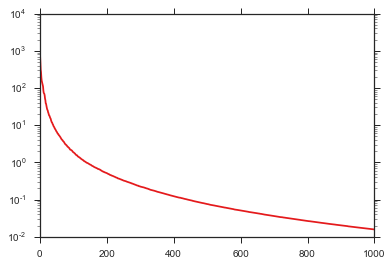

In [145]:
cov = np.cov(new_dat, rowvar=0)
cov = (cov+cov.T)/2.
print 'Symmetric: ', (cov==cov.transpose()).all()
eigs = np.sort(np.linalg.eigvalsh(cov))[::-1]
# plt.imshow(cov)
plt.plot(eigs)
plt.yscale('log')

In [198]:
N,Tdim = new_dat.shape
def sig_MDL(k):
    eigs_k = eigs[k+1:]
    logf = N*np.sum(np.log(eigs_k)) - N*(Tdim-k)*np.log(np.sum(eigs_k)/(Tdim-k))
#     print -logf
    
    G_bias = k*(2*Tdim-k)
#     print 0.5*G_bias*np.log(N)
#     num = np.prod(np.power(eigs_k, 1./(Tdim-k)))
#     print num
#     den = np.sum(eigs_k)/(Tdim-k)
#     print den
#     logf = np.power(np.log(num/den), Tdim-k)*N/2.
    
#     G_bias = 1+Tdim*k - k*(k-1)/2.

    return -logf + 0.5*G_bias*np.log(N)

def sig_AIC(k):
    eigs_k = eigs[k+1:]
    logf = N*np.sum(np.log(eigs_k)) - N*(Tdim-k)*np.log(np.sum(eigs_k)/(Tdim-k))
#     print -logf
    
    G_bias = k*(2*Tdim-k)

    return -2*logf + 2*G_bias

def sig_KIC(k):
    eigs_k = eigs[k+1:]
    logf = N*np.sum(np.log(eigs_k)) - N*(Tdim-k)*np.log(np.sum(eigs_k)/(Tdim-k))
#     print -logf
    
    G_bias = k*(2*Tdim-k)

    return -2*logf + 3*G_bias

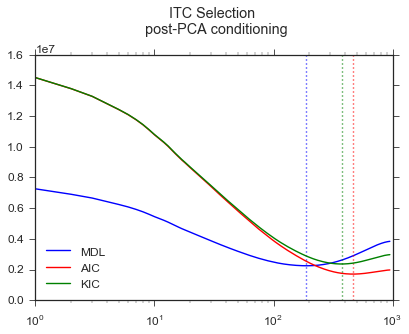

In [199]:
K = range(950)
aic = [sig_AIC(k) for k in K]
mdl = [sig_MDL(k) for k in K]
kic = [sig_KIC(k) for k in K]

plt.plot(K,mdl, 'b', label='MDL')
plt.axvline(x=K[np.argmin(mdl)], c='b', ls=':')

plt.plot(K,aic, 'r', label='AIC')
plt.axvline(x=K[np.argmin(aic)], c='r', ls=':')

plt.plot(K,kic, 'g', label='KIC')
plt.axvline(x=K[np.argmin(kic)], c='g', ls=':')

plt.legend(loc=0)
plt.xscale('log')
plt.title('ITC Selection \n post-PCA conditioning\n')

In [173]:
sig_MDL(30)

3866734.1517842719

In [180]:
print 'MDL min:\t',K[np.argmin(mdl)]
print 'AIC min:\t',K[np.argmin(aic)]
print 'KIC min:\t',K[np.argmin(kic)]

MDL min:	187
AIC min:	464
KIC min:	373


In [186]:
np.exp((np.min(mdl) - mdl[30])/2)

0.0

In [187]:
ica = FastICA(n_components=187)
ica.fit(pre.all_dat)

FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=187, random_state=None, tol=0.0001, w_init=None,
    whiten=True)

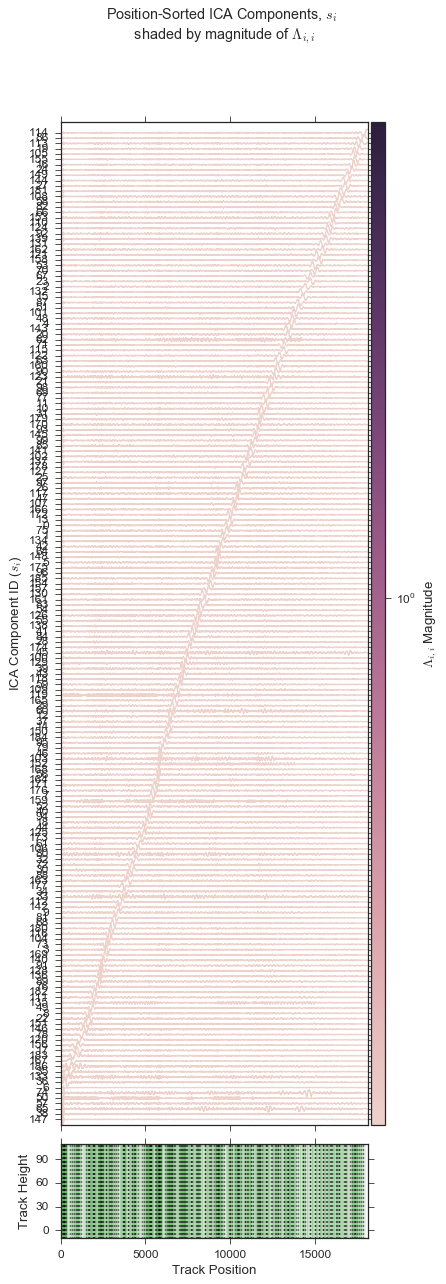

In [195]:
import matplotlib.colors as colors
import matplotlib.cm
# %matplotlib notebook
best_sig = np.ones(187)

sns.set_context(context='paper', font_scale=1.5)

max_pos = np.argmax(np.abs(ica.components_), axis=1)
order = np.argsort(max_pos)
# print order
comp_sort = ica.components_[order]
ordered_sig = np.array(best_sig)[order]

# which = [5,16, 6, 14, 19, 22]
which = range(187)
# ax1 = plt.plot(len(which),1,1)


norm = colors.LogNorm(
    vmin=np.min(ordered_sig),
    vmax=np.max(ordered_sig))

c_m = sns.cubehelix_palette(as_cmap=True)
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])

f = plt.figure(figsize = (6,20))

ax2 = plt.subplot2grid((20,20), (18,0), colspan=19, rowspan=2)
# ax2.plot(np.linspace(0,18160,num=96), data, color='gray')
for n,i in enumerate(max_pos[order]):
    if ordered_sig[n]>0.01:
        ax2.axvline(i, color='k', ls=':')
#         width=4000/(20*np.log10(ordered_sig[n])-20*np.log10(ordered_sig.min()))
        width=181.6*np.exp(-np.log10(ordered_sig[n])-np.log10(ordered_sig.max()))
#         print width
        ax2.axvspan(i-width, i+width, alpha=.1, color='g')
ax2.set_xlim(0,18160)
ax2.set_yticks([0,30,60,90])
ax2.set_ylim(-10,110)
ax2.set_xlabel('Track Position')
ax2.set_ylabel('Track Height')


ax1 = plt.subplot2grid((20,20), (0,0), colspan=19, rowspan=18, sharex=ax2)
# plt.subplot(211)
for n,i in enumerate(which):
#     plt.subplot(len(which),1,n+1, sharex=ax1)
    
    ax1.plot(range(18160),comp_sort[i] + n*0.0015, color=s_m.to_rgba(ordered_sig[i]))
#     if ordered_sig[i]>0.017:
#         plt.plot(range(18160),comp_sort[i] + n*0.0001, 'r')
#     else:
#         plt.plot(range(18160),comp_sort[i] + n*0.0001, 'k')
    
    ax1.set_yticks([0.0015*(i) for i in np.arange(187)])
    ax1.set_yticklabels([str(i) for i in np.arange(187)[order]])
ax1.set_xlim(0,18160)
ax1.set_ylim(-0.0015, 188*0.0015)
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('ICA Component ID ($s_i$)')

plt.subplots_adjust(hspace=0.5, right=.875)
ax3 = plt.subplot2grid((20,20), (0,19), rowspan=18)
plt.colorbar(s_m, ax3)
ax3.set_ylabel('$\Lambda_{i,i}$ Magnitude')

f.suptitle('Position-Sorted ICA Components, $s_i$ \n shaded by magnitude of $\Lambda_{i,i}$')
